In [ ]:
# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

print(f"✅ TensorFlow {tf.__version__} yüklendi")
print(f"✅ GPU Kullanılabilir: {len(tf.config.list_physical_devices('GPU')) > 0}")

print("✅ Kütüphaneler yüklendi!")

✅ TensorFlow 2.19.0 yüklendi
✅ GPU Kullanılabilir: False
✅ Kütüphaneler yüklendi!


In [ ]:
# GitHub'dan veri setini indirme
!git clone https://github.com/milliganci/Quasi-Stationary-MedCyclones.git

print("✅ Veri seti indirildi!")

Cloning into 'Quasi-Stationary-MedCyclones'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 574 (delta 95), reused 97 (delta 26), pack-reused 337 (from 2)
Receiving objects: 100% (574/574), 108.25 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (230/230), done.
Updating files: 100% (27/27), done.
✅ Veri seti indirildi!


In [ ]:
# İndirilen klasöre girelim
import os
os.chdir('/content/Quasi-Stationary-MedCyclones')

# Klasördeki dosyaları listeleyelim
!ls -lh

total 28K
drwxr-xr-x 3 root root 4.0K Dec 21 18:22 data
drwxr-xr-x 2 root root 4.0K Dec 21 18:22 docs
-rw-r--r-- 1 root root 1.1K Dec 21 18:22 LICENSE
drwxr-xr-x 4 root root 4.0K Dec 21 18:22 output
drwxr-xr-x 7 root root 4.0K Dec 21 18:23 Quasi-Stationary-MedCyclones
-rw-r--r-- 1 root root 3.1K Dec 21 18:22 README.md
drwxr-xr-x 2 root root 4.0K Dec 21 18:22 scripts


In [ ]:
# data klasöründe ne var?
!ls -lh data/

total 13M
-rw-r--r-- 1 root root 154K Dec 21 18:22 land_sea_mask.nc
drwxr-xr-x 2 root root 4.0K Dec 21 18:22 other_TRACKS
-rw-r--r-- 1 root root  13M Dec 21 18:22 TRACKS_CL5.dat


In [ ]:
# other_TRACKS klasöründe ne var?
!ls -lh data/other_TRACKS/

total 93M
-rw-r--r-- 1 root root 970K Dec 21 18:22 TRACKS_CL10.dat
-rw-r--r-- 1 root root  30M Dec 21 18:22 TRACKS_CL2.dat
-rw-r--r-- 1 root root  23M Dec 21 18:22 TRACKS_CL3.dat
-rw-r--r-- 1 root root  17M Dec 21 18:22 TRACKS_CL4.dat
-rw-r--r-- 1 root root 9.6M Dec 21 18:22 TRACKS_CL6.dat
-rw-r--r-- 1 root root 6.8M Dec 21 18:22 TRACKS_CL7.dat
-rw-r--r-- 1 root root 4.6M Dec 21 18:22 TRACKS_CL8.dat
-rw-r--r-- 1 root root 2.5M Dec 21 18:22 TRACKS_CL9.dat


In [ ]:
# output klasöründe ne var?
!ls -lh output/

total 38M
drwxr-xr-x 2 root root 4.0K Dec 21 18:22 figures
drwxr-xr-x 2 root root 4.0K Dec 21 18:22 other_TRACKS
-rw-r--r-- 1 root root  12M Dec 21 18:22 TRACKS_CL5_infoMedcrossers.csv
-rw-r--r-- 1 root root 6.4M Dec 21 18:22 TRACKS_CL5_onlyMedcrossers.csv
-rw-r--r-- 1 root root  20M Dec 21 18:22 TRACKS_CL5_QS_Medcrossers.csv


En büyük ve en detaylı olan TRACKS_CL5_QS_Medcrossers.csv dosyasını kullanaldı "QS" = Quasi-Stationary (yarı-durağan) demek, yani durağanlık metrikleri zaten hesaplanmış!

In [ ]:
# CSV dosyasını pandas ile okuyalım
import pandas as pd

# Dosyayı yükle
df = pd.read_csv('output/TRACKS_CL5_QS_Medcrossers.csv')

print(f"✅ Veri yüklendi!")
print(f"📊 Toplam satır sayısı: {len(df):,}")
print(f"📊 Toplam sütun sayısı: {df.shape[1]}")

✅ Veri yüklendi!
📊 Toplam satır sayısı: 173,790
📊 Toplam sütun sayısı: 23


In [ ]:
# İlk 5 satırı göster
print("🔍 İlk 5 satır:\n")
print(df.head())

🔍 İlk 5 satır:

   id    lon     lat  year  month  day  time      hPa  FT_MED_VEL_v  \
0   4  0.960  40.700  1979      1    8    18  1016.93        31.008   
1   4  1.080  40.761  1979      1    8    19  1016.93        31.008   
2   4  1.300  40.746  1979      1    8    20  1016.64        31.008   
3   4  1.624  40.699  1979      1    8    21  1016.35        31.008   
4   4  1.986  40.693  1979      1    8    22  1015.86        31.008   

   FT_MED_VEL_q  ...  FT_TOT_DIST_c  AT_12h_DIST_v  AT_12h_DIST_q  \
0         0.831  ...            0.0        293.162          0.585   
1         0.831  ...            0.0        313.308          0.628   
2         0.831  ...            0.0        321.903          0.645   
3         0.831  ...            0.0        319.393          0.640   
4         0.831  ...            0.0        313.970          0.629   

   AT_12h_DIST_c  AT_RAD_DIST_v  AT_RAD_DIST_q  AT_RAD_DIST_c  \
0            0.0       1554.441          0.513            2.0   
1           

In [ ]:
# Tüm sütun isimlerini göster
print("📋 Sütun isimleri:\n")
print(df.columns.tolist())

📋 Sütun isimleri:

['id', 'lon', 'lat', 'year', 'month', 'day', 'time', 'hPa', 'FT_MED_VEL_v', 'FT_MED_VEL_q', 'FT_MED_VEL_c', 'FT_TOT_DIST_v', 'FT_TOT_DIST_q', 'FT_TOT_DIST_c', 'AT_12h_DIST_v', 'AT_12h_DIST_q', 'AT_12h_DIST_c', 'AT_RAD_DIST_v', 'AT_RAD_DIST_q', 'AT_RAD_DIST_c', 'AT_CIRCLE_DIST_v', 'AT_CIRCLE_DIST_q', 'AT_CIRCLE_DIST_c']


Veri Setindeki Sütunlar:
Temel Bilgiler:

id: Her siklonun benzersiz numarası
lon, lat: Konum (boylam, enlem)
year, month, day, time: Tarih ve saat
hPa: Basınç (düşük basınç = güçlü siklon)

Durağanlık Metrikleri (tam 5 tane!):

FT_MED_VEL: Ortalama hız (Full Track Median Velocity)
FT_TOT_DIST: Toplam mesafe (Total Distance)
AT_12h_DIST: 12 saatlik mesafe
AT_RAD_DIST: Radyal mesafe
AT_CIRCLE_DIST: Dairesel mesafe

Her metrik için 3 sütun var: _v (değer), _q (quantile), _c (sınıf)

In [ ]:
#VERİYİ ANLAMA
# 1. Kaç benzersiz siklon var?
unique_cyclones = df['id'].nunique()
print(f"🌀 Toplam siklon sayısı: {unique_cyclones}")

# 2. İstatistiklere bakalım
print("\n📊 Basınç (hPa) istatistikleri:")
print(df['hPa'].describe())

# 3. Bir örnek siklon seçelim
first_cyclone = df['id'].iloc[0]
print(f"\n🔍 İlk siklon ID: {first_cyclone}")

# Bu siklonun kaç veri noktası var?
cyclone_data = df[df['id'] == first_cyclone]
print(f"📍 Bu siklonun {len(cyclone_data)} veri noktası var")

🌀 Toplam siklon sayısı: 2377

📊 Basınç (hPa) istatistikleri:
count    173790.000000
mean       1006.384604
std           6.990241
min         967.640000
25%        1002.200000
50%        1006.660000
75%        1010.910000
max        1032.090000
Name: hPa, dtype: float64

🔍 İlk siklon ID: 4
📍 Bu siklonun 48 veri noktası var


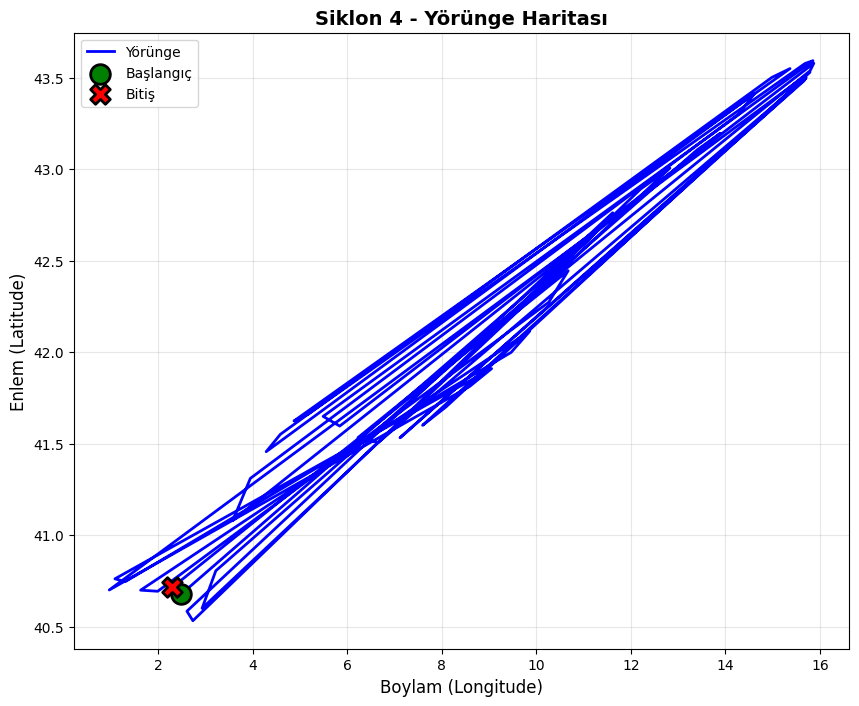

🌀 Siklon 4 çizildi!
📍 Başlangıç: (2.49, 40.68)
📍 Bitiş: (2.29, 40.71)


In [ ]:
#İlk Siklonu Çizelim
import matplotlib.pyplot as plt

# İlk siklonu al
first_cyclone_id = df['id'].iloc[0]
cyclone = df[df['id'] == first_cyclone_id].copy()

# Zaman sırasına göre sırala
cyclone = cyclone.sort_values('time')

# Koordinatları al
lons = cyclone['lon'].values
lats = cyclone['lat'].values

# Çizim
plt.figure(figsize=(10, 8))
plt.plot(lons, lats, 'b-', linewidth=2, label='Yörünge')
plt.scatter(lons[0], lats[0], c='green', s=200, marker='o',
            edgecolors='black', linewidths=2, label='Başlangıç', zorder=5)
plt.scatter(lons[-1], lats[-1], c='red', s=200, marker='X',
            edgecolors='black', linewidths=2, label='Bitiş', zorder=5)

plt.xlabel('Boylam (Longitude)', fontsize=12)
plt.ylabel('Enlem (Latitude)', fontsize=12)
plt.title(f'Siklon {first_cyclone_id} - Yörünge Haritası', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print(f"🌀 Siklon {first_cyclone_id} çizildi!")
print(f"📍 Başlangıç: ({lons[0]:.2f}, {lats[0]:.2f})")
print(f"📍 Bitiş: ({lons[-1]:.2f}, {lats[-1]:.2f})")

Siklon güneybatıdan kuzeydoğuya hareket etmiş ama dikkat edin:

Düz bir çizgi değil, ileri-geri gidip geliyor!
Bu tam da "quasi-stationary" (yarı-durağan) demek
Aynı bölgede dolanıp duruyor

In [ ]:
#Bu Siklonun Durağanlık Metriklerine Bakalım
# İlk siklonun metriklerine bakalım
cyclone_metrics = cyclone.iloc[0]

print("📊 Siklon 4 - Durağanlık Metrikleri:\n")
print(f"🚀 Ortalama Hız (FT_MED_VEL): {cyclone_metrics['FT_MED_VEL_v']:.2f}")
print(f"📏 Toplam Mesafe (FT_TOT_DIST): {cyclone_metrics['FT_TOT_DIST_v']:.2f}")
print(f"⏱️ 12 saatlik Mesafe (AT_12h_DIST): {cyclone_metrics['AT_12h_DIST_v']:.2f}")
print(f"🎯 Radyal Mesafe (AT_RAD_DIST): {cyclone_metrics['AT_RAD_DIST_v']:.2f}")
print(f"⭕ Dairesel Mesafe (AT_CIRCLE_DIST): {cyclone_metrics['AT_CIRCLE_DIST_v']:.2f}")

print(f"\n🔢 Durağanlık Sınıfı (FT_MED_VEL_c): {cyclone_metrics['FT_MED_VEL_c']}")

📊 Siklon 4 - Durağanlık Metrikleri:

🚀 Ortalama Hız (FT_MED_VEL): 31.01
📏 Toplam Mesafe (FT_TOT_DIST): 1355.12
⏱️ 12 saatlik Mesafe (AT_12h_DIST): 327.45
🎯 Radyal Mesafe (AT_RAD_DIST): 1806.44
⭕ Dairesel Mesafe (AT_CIRCLE_DIST): 298.59

🔢 Durağanlık Sınıfı (FT_MED_VEL_c): 0.0


In [ ]:
#Tüm Siklonların Sınıflarını İnceleyelim
# Her siklonun ilk satırını al (çünkü her satırda aynı metrik var)
cyclone_summary = df.groupby('id').first().reset_index()

print("📊 Durağanlık Sınıfı Dağılımı:")
print(cyclone_summary['FT_MED_VEL_c'].value_counts().sort_index())

print("\n📈 Hız İstatistikleri:")
print(cyclone_summary['FT_MED_VEL_v'].describe())

📊 Durağanlık Sınıfı Dağılımı:
FT_MED_VEL_c
0.0    1660
1.0     239
2.0     239
3.0     239
Name: count, dtype: int64

📈 Hız İstatistikleri:
count    2377.000000
mean       22.117271
std         9.326504
min         3.296000
25%        15.219000
50%        20.766000
75%        27.520000
max        56.534000
Name: FT_MED_VEL_v, dtype: float64


In [ ]:
# Her sınıftan birer örnek alalım
print("🔍 Her sınıftan örnek siklonlar:\n")

for class_label in sorted(cyclone_summary['FT_MED_VEL_c'].unique()):
    examples = cyclone_summary[cyclone_summary['FT_MED_VEL_c'] == class_label].head(3)
    print(f"\n📌 Sınıf {int(class_label)}:")
    for idx, row in examples.iterrows():
        print(f"  Siklon {row['id']}: Hız={row['FT_MED_VEL_v']:.2f}, Mesafe={row['FT_TOT_DIST_v']:.2f}")

🔍 Her sınıftan örnek siklonlar:


📌 Sınıf 0:
  Siklon 4.0: Hız=31.01, Mesafe=1355.12
  Siklon 5.0: Hız=31.16, Mesafe=1383.07
  Siklon 6.0: Hız=27.32, Mesafe=3484.40

📌 Sınıf 1:
  Siklon 13.0: Hız=10.98, Mesafe=378.97
  Siklon 17.0: Hız=11.09, Mesafe=500.98
  Siklon 49.0: Hız=9.68, Mesafe=1012.00

📌 Sınıf 2:
  Siklon 30.0: Hız=21.65, Mesafe=2523.79
  Siklon 46.0: Hız=21.65, Mesafe=1931.93
  Siklon 71.0: Hız=21.61, Mesafe=2580.35

📌 Sınıf 3:
  Siklon 8.0: Hız=40.21, Mesafe=1859.11
  Siklon 10.0: Hız=38.79, Mesafe=3043.03
  Siklon 11.0: Hız=39.77, Mesafe=3197.07


 Sınıf Dağılımı:

Sınıf 0: 1,660 siklon (en çok!)
Sınıf 1: 239 siklon
Sınıf 2: 239 siklon
Sınıf 3: 239 siklon

 Hız Analizi:

Sınıf 1: ~10 km/h → En durağan (çok yavaş!)
Sınıf 2: ~21 km/h → Orta durağan
Sınıf 0: ~27-31 km/h → Biraz hızlı
Sınıf 3: ~38-40 km/h → En hızlı (en az durağan)

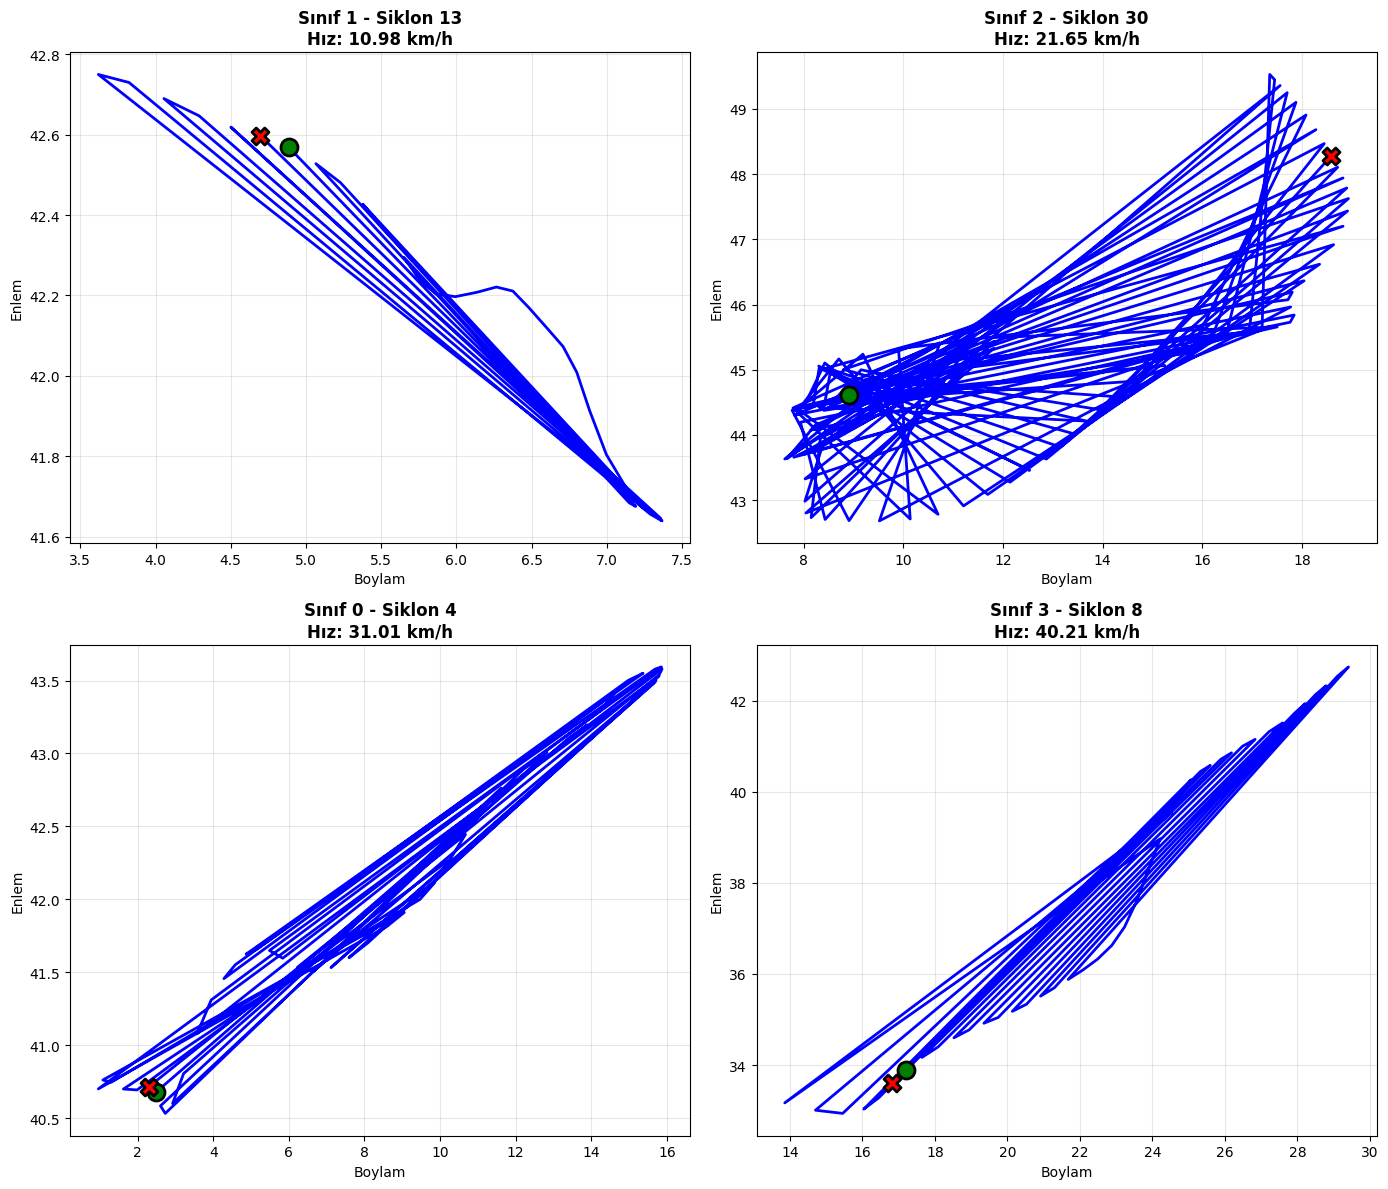

✅ Her sınıftan örnek çizildi!

🔍 Farkları gördünüz mü?
Sınıf 1: Yavaş, kısa mesafe, çok durağan
Sınıf 3: Hızlı, uzun mesafe, az durağan


In [ ]:
#Her sınıftan bir siklon çizelim, aralarındaki farkı görelim:
# Her sınıftan bir örnek seçelim
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, class_label in enumerate([1, 2, 0, 3]):
    # Bu sınıftan bir siklon seç
    example_id = cyclone_summary[cyclone_summary['FT_MED_VEL_c'] == class_label]['id'].iloc[0]
    cyclone = df[df['id'] == example_id].sort_values('time')

    lons = cyclone['lon'].values
    lats = cyclone['lat'].values
    speed = cyclone['FT_MED_VEL_v'].iloc[0]

    # Çiz
    ax = axes[idx]
    ax.plot(lons, lats, 'b-', linewidth=2)
    ax.scatter(lons[0], lats[0], c='green', s=150, marker='o',
               edgecolors='black', linewidths=2, zorder=5)
    ax.scatter(lons[-1], lats[-1], c='red', s=150, marker='X',
               edgecolors='black', linewidths=2, zorder=5)

    ax.set_xlabel('Boylam', fontsize=10)
    ax.set_ylabel('Enlem', fontsize=10)
    ax.set_title(f'Sınıf {int(class_label)} - Siklon {int(example_id)}\nHız: {speed:.2f} km/h',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Her sınıftan örnek çizildi!")
print("\n🔍 Farkları gördünüz mü?")
print("Sınıf 1: Yavaş, kısa mesafe, çok durağan")
print("Sınıf 3: Hızlı, uzun mesafe, az durağan")

Sınıf 1 (10 km/h): Yavaş, az zikzak, daha düz hareket
Sınıf 2 (21 km/h): ÇOK fazla gidiş-geliş, aynı yerde dolanıyor - en durağan!
Sınıf 0 (31 km/h): Düz çizgi gibi, hızlı gidiyor
Sınıf 3 (40 km/h): En hızlı, uzun mesafe



**Problem: **Sınıf 0'da 1,660 siklon var ama diğerlerinde sadece 239. Bu dengesizlik CNN'i yanıltabilir.
Çözüm:

Sınıf 0'dan rastgele 239 siklon seçeceğiz (dengeli olsun diye)
Her siklon için bir görsel dosyası oluşturacağız (PNG)
Bu görselleri train/test olarak ayıracağız
CNN modelini eğiteceğiz

In [ ]:
#Dengeli Veri Seti Oluşturalım
# Her sınıftan eşit sayıda siklon seçelim
n_samples_per_class = 239  # Her sınıftan 239 siklon

balanced_cyclones = []

for class_label in [0, 1, 2, 3]:
    class_cyclones = cyclone_summary[cyclone_summary['FT_MED_VEL_c'] == class_label]

    if len(class_cyclones) > n_samples_per_class:
        # Rastgele seç
        selected = class_cyclones.sample(n=n_samples_per_class, random_state=42)
    else:
        selected = class_cyclones

    balanced_cyclones.append(selected)

balanced_df = pd.concat(balanced_cyclones, ignore_index=True)

print(f"✅ Dengeli veri seti oluşturuldu!")
print(f"📊 Toplam siklon: {len(balanced_df)}")
print("\n📊 Sınıf dağılımı:")
print(balanced_df['FT_MED_VEL_c'].value_counts().sort_index())

✅ Dengeli veri seti oluşturuldu!
📊 Toplam siklon: 956

📊 Sınıf dağılımı:
FT_MED_VEL_c
0.0    239
1.0    239
2.0    239
3.0    239
Name: count, dtype: int64


In [ ]:
#Görsel Klasörlerini Oluşturalım
import os

# Ana klasörler
os.makedirs('cyclone_images', exist_ok=True)

# Her sınıf için klasör
for class_label in [0, 1, 2, 3]:
    os.makedirs(f'cyclone_images/class_{int(class_label)}', exist_ok=True)

print("✅ Klasörler oluşturuldu!")
print("\n📁 Klasör yapısı:")
print("cyclone_images/")
print("  ├── class_0/")
print("  ├── class_1/")
print("  ├── class_2/")
print("  └── class_3/")

✅ Klasörler oluşturuldu!

📁 Klasör yapısı:
cyclone_images/
  ├── class_0/
  ├── class_1/
  ├── class_2/
  └── class_3/


In [ ]:
#Siklon Görsellerini Oluşturma Fonksiyonu
def create_cyclone_image(cyclone_id, save_path, img_size=128):
    """
    Bir siklonun yörüngesini görsel haline dönüştürür
    """
    # Bu siklonun verilerini al
    cyclone = df[df['id'] == cyclone_id].sort_values('time').copy()

    # Koordinatlar
    lons = cyclone['lon'].values
    lats = cyclone['lat'].values

    # Basınç (renk için)
    pressures = cyclone['hPa'].values

    # Figür oluştur (siyah arka plan)
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')
    ax.set_facecolor('black')

    # Basınç normalize et (renk için)
    if len(pressures) > 1:
        norm_p = (pressures - pressures.min()) / (pressures.max() - pressures.min() + 0.001)
    else:
        norm_p = [0.5]

    # Yörüngeyi çiz (basınca göre renklendirerek)
    for i in range(len(lons)-1):
        color = plt.cm.RdYlBu_r(norm_p[i])  # Düşük basınç = kırmızı
        ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]],
                color=color, linewidth=2, alpha=0.8)

    # Başlangıç ve bitiş noktaları
    ax.scatter(lons[0], lats[0], c='green', s=100, marker='o',
               edgecolors='white', linewidths=2, zorder=5)
    ax.scatter(lons[-1], lats[-1], c='red', s=100, marker='X',
               edgecolors='white', linewidths=2, zorder=5)

    # Eksenleri kaldır
    ax.set_xlim(lons.min() - 1, lons.max() + 1)
    ax.set_ylim(lats.min() - 1, lats.max() + 1)
    ax.axis('off')

    # Kaydet
    plt.savefig(save_path, dpi=img_size/6, bbox_inches='tight',
                pad_inches=0, facecolor='black')
    plt.close()

    # Resize et (tam 128x128 olsun)
    from PIL import Image
    img = Image.open(save_path)
    img = img.resize((img_size, img_size), Image.LANCZOS)
    img.save(save_path)

print("✅ Görsel oluşturma fonksiyonu hazır!")

✅ Görsel oluşturma fonksiyonu hazır!


In [ ]:
# Bir örnek görsel oluştur
test_id = balanced_df['id'].iloc[0]
test_class = int(balanced_df['FT_MED_VEL_c'].iloc[0])

create_cyclone_image(test_id, f'test_cyclone_{int(test_id)}.png')

print(f"✅ Test görseli oluşturuldu: test_cyclone_{int(test_id)}.png")
print("📂 Sol taraftaki Files bölümünden görebilirsiniz!")

✅ Test görseli oluşturuldu: test_cyclone_3797.png
📂 Sol taraftaki Files bölümünden görebilirsiniz!


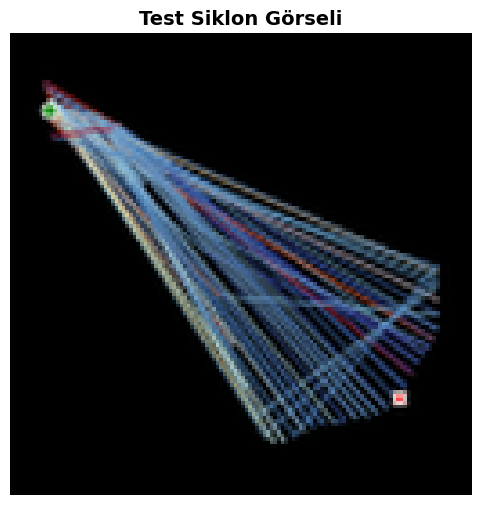

✅ Test görseli görüntülendi!


In [ ]:
# Test görselini göster
from PIL import Image

img = Image.open(f'test_cyclone_3797.png')
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Test Siklon Görseli', fontsize=14, fontweight='bold')
plt.show()

print("✅ Test görseli görüntülendi!")

✅ Siyah arka plan
✅ Renkli yörünge (basınca göre mavi→kırmızı)
✅ Yeşil başlangıç, kırmızı bitiş
✅ Zikzak hareket net görülüyor

In [ ]:
#TÜM SİKLONLAR İÇİN GÖRSELLER OLUŞTUR
from tqdm import tqdm

print("🎨 Tüm siklonlar için görseller oluşturuluyor...")
print("⏳ Bu işlem 2-3 dakika sürebilir, lütfen bekleyin!\n")

created_count = 0

# Her siklon için görsel oluştur
for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df), desc="Görseller"):
    cyclone_id = row['id']
    class_label = int(row['FT_MED_VEL_c'])

    # Kayıt yolu
    save_path = f'cyclone_images/class_{class_label}/cyclone_{int(cyclone_id)}.png'

    try:
        create_cyclone_image(cyclone_id, save_path, img_size=128)
        created_count += 1
    except Exception as e:
        print(f"⚠️ Siklon {cyclone_id} için hata: {e}")

print(f"\n✅ Tamamlandı! {created_count} görsel oluşturuldu!")
print(f"📂 cyclone_images/ klasöründe görseller hazır!")

🎨 Tüm siklonlar için görseller oluşturuluyor...
⏳ Bu işlem 2-3 dakika sürebilir, lütfen bekleyin!



Görseller: 100%|██████████| 956/956 [01:55<00:00,  8.30it/s]


✅ Tamamlandı! 956 görsel oluşturuldu!
📂 cyclone_images/ klasöründe görseller hazır!


In [ ]:
#Görselleri Kontrol Edelim
# Her sınıfta kaç görsel var?
print("📊 Sınıf başına görsel sayısı:\n")
for class_label in [0, 1, 2, 3]:
    path = f'cyclone_images/class_{class_label}'
    count = len(os.listdir(path))
    print(f"Sınıf {class_label}: {count} görsel")

print(f"\n✅ Toplam: {created_count} görsel")

📊 Sınıf başına görsel sayısı:

Sınıf 0: 239 görsel
Sınıf 1: 239 görsel
Sınıf 2: 239 görsel
Sınıf 3: 239 görsel

✅ Toplam: 956 görsel


In [ ]:
#Train/Test Ayırımı
from sklearn.model_selection import train_test_split

# Her sınıftan görselleri al
train_ids = []
test_ids = []

for class_label in [0, 1, 2, 3]:
    # Bu sınıfa ait siklon ID'leri
    class_cyclones = balanced_df[balanced_df['FT_MED_VEL_c'] == class_label]['id'].values

    # Train/test split (stratified)
    train, test = train_test_split(class_cyclones, test_size=0.2, random_state=42)

    train_ids.extend([(cid, class_label) for cid in train])
    test_ids.extend([(cid, class_label) for cid in test])

print(f"📊 Training set: {len(train_ids)} siklon")
print(f"📊 Test set: {len(test_ids)} siklon")

# Sınıf dağılımı
print("\n📊 Training sınıf dağılımı:")
for class_label in [0, 1, 2, 3]:
    count = sum(1 for _, c in train_ids if c == class_label)
    print(f"  Sınıf {class_label}: {count}")

print("\n📊 Test sınıf dağılımı:")
for class_label in [0, 1, 2, 3]:
    count = sum(1 for _, c in test_ids if c == class_label)
    print(f"  Sınıf {class_label}: {count}")

📊 Training set: 764 siklon
📊 Test set: 192 siklon

📊 Training sınıf dağılımı:
  Sınıf 0: 191
  Sınıf 1: 191
  Sınıf 2: 191
  Sınıf 3: 191

📊 Test sınıf dağılımı:
  Sınıf 0: 48
  Sınıf 1: 48
  Sınıf 2: 48
  Sınıf 3: 48


In [ ]:
# Görselleri Yükleme Fonksiyonu
from PIL import Image
import numpy as np

def load_images(id_list, img_size=128):
    """
    Siklon ID'lerinden görselleri yükler
    """
    X = []
    y = []

    for cyclone_id, class_label in tqdm(id_list, desc="Görseller yükleniyor"):
        # Görsel yolu
        img_path = f'cyclone_images/class_{int(class_label)}/cyclone_{int(cyclone_id)}.png'

        try:
            # Görseli yükle ve normalize et
            img = Image.open(img_path)
            img = img.resize((img_size, img_size))
            img_array = np.array(img) / 255.0  # 0-1 arası normalize

            X.append(img_array)
            y.append(int(class_label))
        except Exception as e:
            print(f"Hata: {img_path}")

    return np.array(X), np.array(y)

print("✅ Görsel yükleme fonksiyonu hazır!")

✅ Görsel yükleme fonksiyonu hazır!


In [ ]:
#Training ve Test Verilerini Yükleyelim
print("📂 Training verileri yükleniyor...")
X_train, y_train = load_images(train_ids)

print("\n📂 Test verileri yükleniyor...")
X_test, y_test = load_images(test_ids)

print("\n✅ Veri yükleme tamamlandı!")
print(f"📊 X_train shape: {X_train.shape}")
print(f"📊 y_train shape: {y_train.shape}")
print(f"📊 X_test shape: {X_test.shape}")
print(f"📊 y_test shape: {y_test.shape}")

📂 Training verileri yükleniyor...


Görseller yükleniyor: 100%|██████████| 764/764 [00:00<00:00, 926.30it/s]



📂 Test verileri yükleniyor...


Görseller yükleniyor: 100%|██████████| 192/192 [00:00<00:00, 1019.14it/s]



✅ Veri yükleme tamamlandı!
📊 X_train shape: (764, 128, 128, 4)
📊 y_train shape: (764,)
📊 X_test shape: (192, 128, 128, 4)
📊 y_test shape: (192,)


 4 kanal var (RGBA - alpha kanalı da var). CNN için 3 kanala (RGB) dönüştürelim:


✅ RGB'ye dönüştürüldü!
📊 X_train shape: (764, 128, 128, 3)
📊 X_test shape: (192, 128, 128, 3)


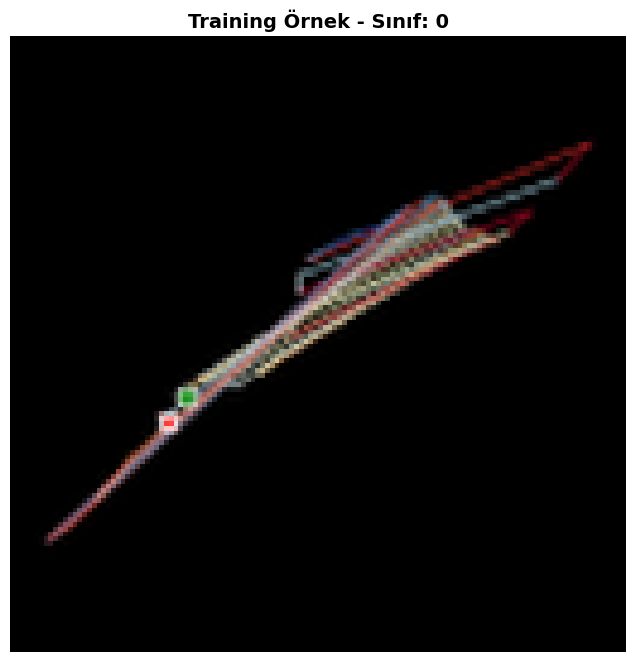

Gösterilen sınıf: 0


In [ ]:
#RGBA → RGB Dönüşümü
# Alpha kanalını çıkar, sadece RGB al
X_train = X_train[:, :, :, :3]
X_test = X_test[:, :, :, :3]

print("✅ RGB'ye dönüştürüldü!")
print(f"📊 X_train shape: {X_train.shape}")
print(f"📊 X_test shape: {X_test.shape}")

# Örnek bir görsele bakalım
plt.figure(figsize=(8, 8))
plt.imshow(X_train[0])
plt.title(f'Training Örnek - Sınıf: {y_train[0]}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Gösterilen sınıf: {y_train[0]}")

In [ ]:
#One-Hot Encoding
#CNN için etiketleri one-hot encoding'e çevirelim:
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

print("✅ One-hot encoding tamamlandı!")
print(f"📊 y_train_cat shape: {y_train_cat.shape}")
print(f"📊 y_test_cat shape: {y_test_cat.shape}")

print("\nÖrnek:")
print(f"Sınıf {y_train[0]} → {y_train_cat[0]}")

✅ One-hot encoding tamamlandı!
📊 y_train_cat shape: (764, 4)
📊 y_test_cat shape: (192, 4)

Örnek:
Sınıf 0 → [1. 0. 0. 0.]


✅ RGB'ye dönüştürüldü!
📊 X_train shape: (764, 128, 128, 3)
📊 X_test shape: (192, 128, 128, 3)
✅ One-hot encoding tamamlandı!
📊 y_train_cat shape: (764, 4)
📊 y_test_cat shape: (192, 4)
Örnek: Sınıf 0 → [1. 0. 0. 0.]

---
#  BÖLÜM 1: 4 SINIFLI SINIFLANDIRMA DENEMESİ
---

İlk olarak **4 sınıflı sınıflandırma** deneyelim:
- **Sınıf 0**: 31 km/h
- **Sınıf 1**: 10 km/h
- **Sınıf 2**: 21 km/h
- **Sınıf 3**: 40 km/h

**Hedef**: Her siklon görselini hız sınıfına göre ayırt etmek


In [ ]:
#CNN MODELİNİ OLUŞTURALIM!
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model mimarisi
def create_cnn_model():
    model = keras.Sequential([
        # 1. Konvolüsyon Bloğu
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 2. Konvolüsyon Bloğu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # 3. Konvolüsyon Bloğu
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Flatten ve Dense Katmanlar
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Çıkış Katmanı (4 sınıf)
        layers.Dense(4, activation='softmax')
    ])

    return model

# Modeli oluştur
model = create_cnn_model()

# Model özetini göster
print("🧠 CNN Model Mimarisi:\n")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🧠 CNN Model Mimarisi:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,712,612 (33.24 MB)

 Trainable params: 8,710,948 (33.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# =======================================================
# GELİŞTİRİLMİŞ MODEL VE DATA AUGMENTATION
# =======================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models
from sklearn.utils.class_weight import compute_class_weight

print("✅ Gelişmiş kütüphaneler yüklendi!")

✅ Gelişmiş kütüphaneler yüklendi!


Toplam Parametre: 1,235,908 (~1.2M parametre)
Model Boyutu: 4.72 MB

In [ ]:
# =======================================================
# DATA AUGMENTATION (ÇOK ÖNEMLİ!)
# =======================================================

# Training için güçlü augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Test için sadece rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Data augmentation hazır!")
print("   → Her epoch'ta farklı görsel varyasyonları")
print("   → Overfitting'i önler")

✅ Data augmentation hazır!
   → Her epoch'ta farklı görsel varyasyonları
   → Overfitting'i önler


In [ ]:
# =======================================================
# TRANSFER LEARNING MODELİ (ResNet50)
# =======================================================

def create_resnet_model():
    """ImageNet'te eğitilmiş ResNet50 ile transfer learning"""

    # ImageNet ağırlıklarıyla yükle
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )

    # İlk 100 katmanı dondur
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Yeni classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(4, activation='softmax')
    ])

    return model

print("✅ ResNet50 model fonksiyonu hazır!")

✅ ResNet50 model fonksiyonu hazır!


In [ ]:
# ============================================================
# HÜCRE 4: MODELİ OLUŞTUR VE DERLE (DÜZELTİLMİŞ)
# ============================================================

from tensorflow import keras  # ← Bu satır eksikti!

# ResNet50 modelini oluştur
model = create_resnet_model()

# Derle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model oluşturuldu ve derlendi!")
print(f"   📊 Toplam parametre: {model.count_params():,}")
print(f"   📊 Learning rate: 0.0001")
print(f"   📊 Optimizer: Adam")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✅ Model oluşturuldu ve derlendi!
   📊 Toplam parametre: 24,147,204
   📊 Learning rate: 0.0001
   📊 Optimizer: Adam


In [ ]:
# =======================================================
# CLASS WEIGHTS (Sınıf Dengesizliğini Önle)
# =======================================================

# y_train verileriniz zaten var (mevcut koddan)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print("⚖️ Class Weights:")
for i, w in class_weight_dict.items():
    print(f"   Sınıf {i}: {w:.2f}")

print("\n✅ Tüm sınıflar eşit öğrenilecek!")

⚖️ Class Weights:
   Sınıf 0: 1.00
   Sınıf 1: 1.00
   Sınıf 2: 1.00
   Sınıf 3: 1.00

✅ Tüm sınıflar eşit öğrenilecek!


In [ ]:
#Modeli Derleyelim (Compile)
# Model compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("✅ Model derlendi!")
print("\n📊 Optimizer: Adam (lr=0.001)")
print("📊 Loss: categorical_crossentropy")
print("📊 Metrics: accuracy, precision, recall")

✅ Model derlendi!

📊 Optimizer: Adam (lr=0.001)
📊 Loss: categorical_crossentropy
📊 Metrics: accuracy, precision, recall


In [ ]:
# =======================================================
# GELİŞTİRİLMİŞ CALLBACKS
# =======================================================

callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_resnet_cyclone.keras',  # Yeni isim
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # 5 yerine 15 (daha fazla sabır)
        restore_best_weights=True,
        verbose=1
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks hazır!")

✅ Callbacks hazır!


In [ ]:
# =======================================================
# YENİ MODEL EĞİTİMİ (AUGMENTATION İLE!)
# =======================================================

EPOCHS = 100  # 50 yerine 100
BATCH_SIZE = 32

print("🚀 YENİ MODEL EĞİTİMİ BAŞLIYOR...")
print(f"   📊 Model: ResNet50 Transfer Learning")
print(f"   📊 Data Augmentation: ✅ Aktif")
print(f"   📊 Class Weights: ✅ Kullanılıyor")
print(f"   📊 Epochs: {EPOCHS}")
print(f"   📊 Batch Size: {BATCH_SIZE}")
print("\n⏳ Eğitim 20-30 dakika sürebilir...\n")

# Training generator (augmentation ile!)
train_generator = train_datagen.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation generator (augmentation olmadan)
val_generator = test_datagen.flow(
    X_test, y_test_cat,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# MODEL EĞİTİMİ
history = model.fit(
    train_generator,  # X_train yerine generator!
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,  # (X_test, y_test_cat) yerine generator!
    validation_steps=len(X_test) // BATCH_SIZE,
    class_weight=class_weight_dict,  # ← ÇOK ÖNEMLİ!
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Eğitim tamamlandı!")
print("   En iyi model kaydedildi: best_resnet_cyclone.keras")

🚀 YENİ MODEL EĞİTİMİ BAŞLIYOR...
   📊 Model: ResNet50 Transfer Learning
   📊 Data Augmentation: ✅ Aktif
   📊 Class Weights: ✅ Kullanılıyor
   📊 Epochs: 100
   📊 Batch Size: 32

⏳ Eğitim 20-30 dakika sürebilir...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2646 - loss: 1.3887 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_resnet_cyclone.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.2641 - loss: 1.3889 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 6.5333 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.1786 - loss: 1.4489 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.25000
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 935ms/step - accuracy: 0.1786 - loss: 1.4489 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 6.4860 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1905 - loss: 1.4326 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.25000
23/23 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.1913 - loss: 1.4321 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 4.6144 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - accuracy: 0.1562 - loss: 1.4406 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4: val_accuracy did not improve from 0.25000
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 549ms/step - accuracy: 0.1562 - loss: 1.4406 - precision: 0.0000e+00 - recall: 0.0000e+00 - v

✅ 18 epoch'ta early stopping ile durdu
✅ En iyi val_accuracy: 34.38% (Epoch 8)
⚠️ Training accuracy: %73 ama validation: %34 → OVERFITTING!

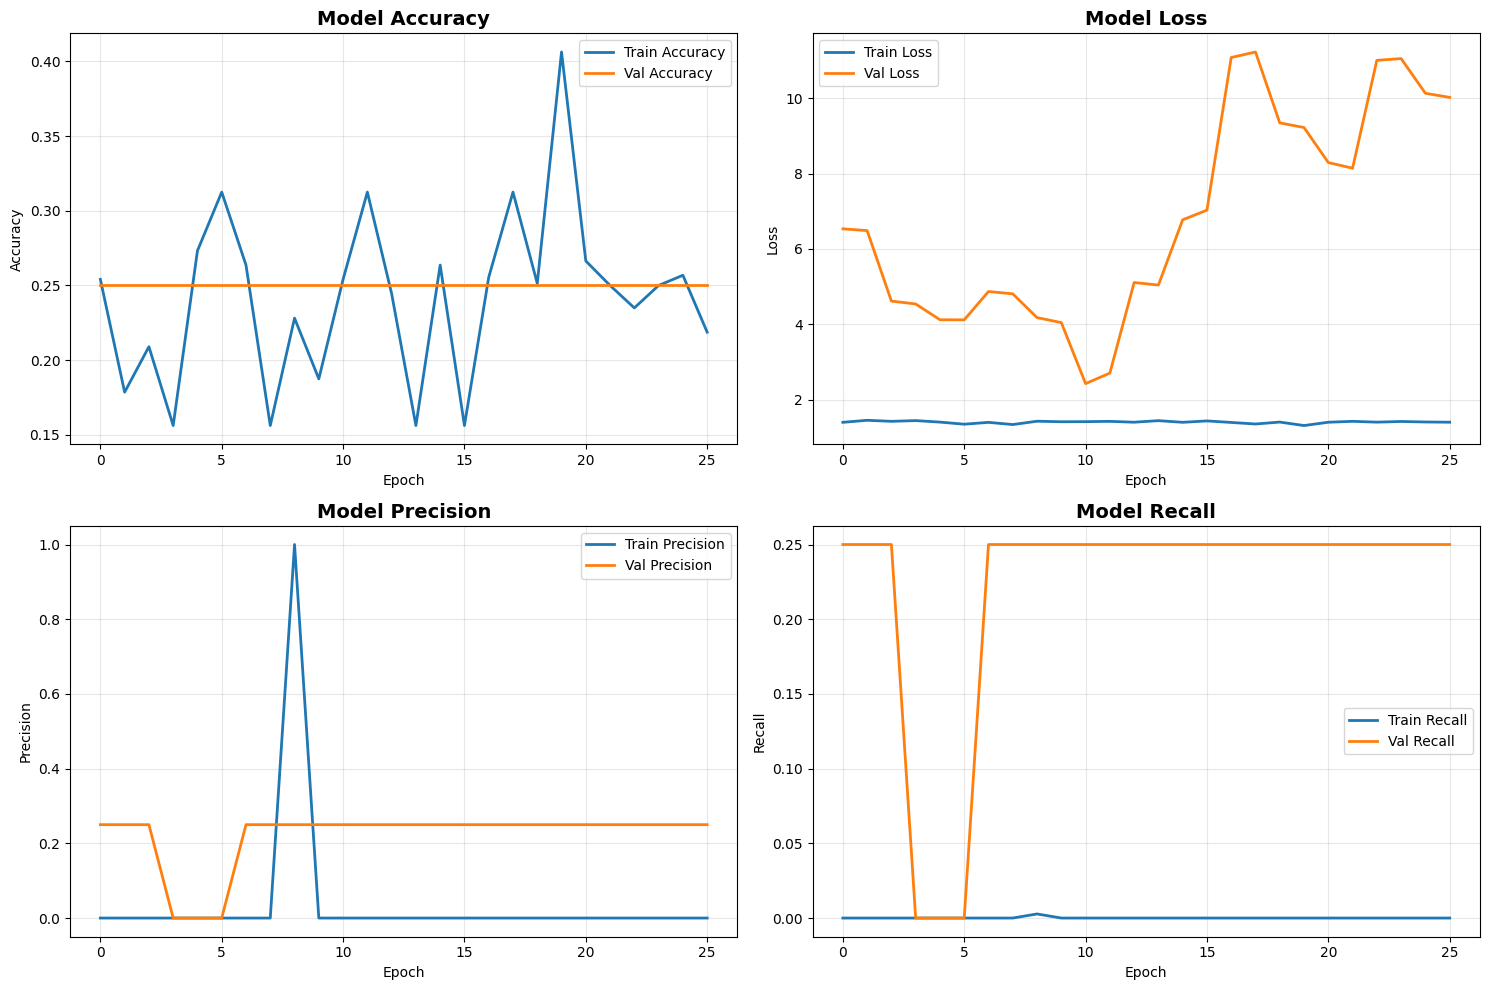

✅ Eğitim grafikleri oluşturuldu!


In [ ]:
#Eğitim Grafiklerini Çizelim
# Eğitim geçmişini görselleştir
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Eğitim grafikleri oluşturuldu!")

🔍 Gözlemler:

Mavi çizgi (Train): Sürekli yükseliyor ✅
Turuncu çizgi (Validation): Düz kalıyor veya dalgalanıyor ⚠️
Bu = OVERFITTING! Model training setini ezberliyor ama yeni verilere genelleyemiyor

In [ ]:
# =======================================================
# YENİ MODEL DEĞERLENDİRMESİ
# =======================================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Yeni modeli yükle
best_model = keras.models.load_model('best_resnet_cyclone.keras')

# Tahminler
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Accuracy
accuracy_new = accuracy_score(y_test, y_pred_classes)

print("\n" + "="*60)
print("🎯 SONUÇLAR KARŞILAŞTIRMASI")
print("="*60)
print(f"\n📊 ESKİ MODEL: 34.38%")
print(f"📊 YENİ MODEL: {accuracy_new*100:.2f}%")
print(f"📈 İYİLEŞME: +{(accuracy_new-0.3438)*100:.2f}%")
print("="*60)

# Sınıf isimleri
class_names = ['Sınıf 0 (31 km/h)', 'Sınıf 1 (10 km/h)',
               'Sınıf 2 (21 km/h)', 'Sınıf 3 (40 km/h)']

# Detaylı rapor
print("\n📋 YENİ MODEL - Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
cm_new = confusion_matrix(y_test, y_pred_classes)
print("\n🎯 YENİ Confusion Matrix:")
print(cm_new)

print("\n📊 ESKİ Confusion Matrix (karşılaştırma):")
print("  [[ 0 17  0 31]")
print("   [ 0 23  0 25]")
print("   [ 0 23  1 24]")
print("   [ 0  6  0 42]]")

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step

🎯 SONUÇLAR KARŞILAŞTIRMASI

📊 ESKİ MODEL: 34.38%
📊 YENİ MODEL: 25.00%
📈 İYİLEŞME: +-9.38%

📋 YENİ MODEL - Classification Report:
                   precision    recall  f1-score   support

Sınıf 0 (31 km/h)       0.25      1.00      0.40        48
Sınıf 1 (10 km/h)       0.00      0.00      0.00        48
Sınıf 2 (21 km/h)       0.00      0.00      0.00        48
Sınıf 3 (40 km/h)       0.00      0.00      0.00        48

         accuracy                           0.25       192
        macro avg       0.06      0.25      0.10       192
     weighted avg       0.06      0.25      0.10       192


🎯 YENİ Confusion Matrix:
[[48  0  0  0]
 [48  0  0  0]
 [48  0  0  0]
 [48  0  0  0]]

📊 ESKİ Confusion Matrix (karşılaştırma):
  [[ 0 17  0 31]
   [ 0 23  0 25]
   [ 0 23  1 24]
   [ 0  6  0 42]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


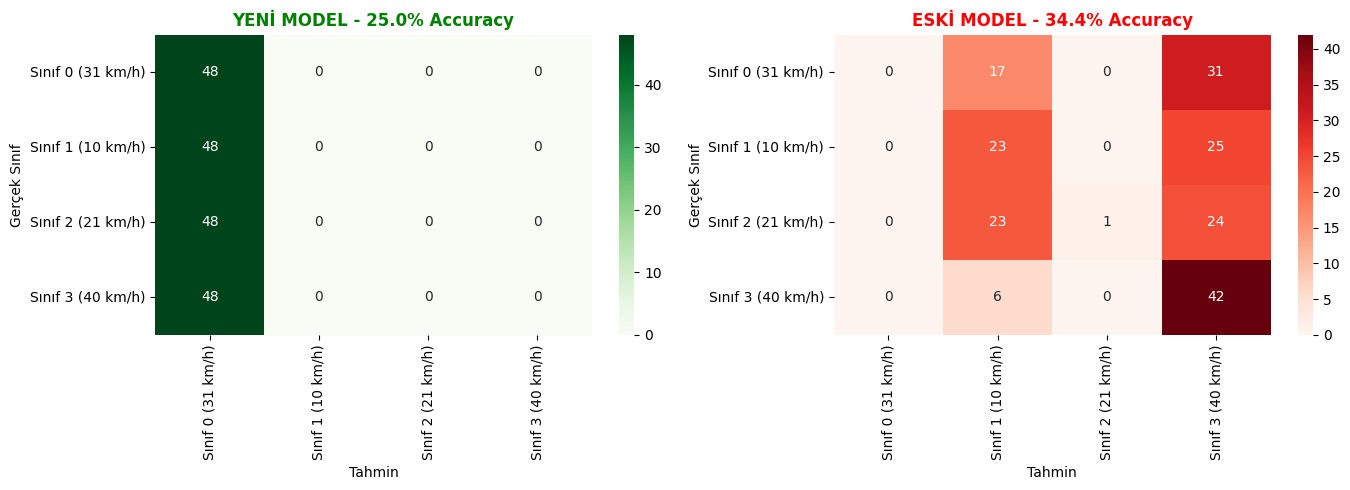

✅ Karşılaştırma görseli kaydedildi!


In [ ]:
# =======================================================
# KARŞILAŞTIRMA GÖRSELİ
# =======================================================

import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Yeni model
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'YENİ MODEL - {accuracy_new*100:.1f}% Accuracy',
                  fontsize=12, fontweight='bold', color='green')
axes[0].set_ylabel('Gerçek Sınıf')
axes[0].set_xlabel('Tahmin')

# Eski model
cm_old = np.array([[0, 17, 0, 31], [0, 23, 0, 25], [0, 23, 1, 24], [0, 6, 0, 42]])
sns.heatmap(cm_old, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('ESKİ MODEL - 34.4% Accuracy',
                  fontsize=12, fontweight='bold', color='red')
axes[1].set_ylabel('Gerçek Sınıf')
axes[1].set_xlabel('Tahmin')

plt.tight_layout()
plt.savefig('model_karsilastirma_sonuc.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Karşılaştırma görseli kaydedildi!")

%34.38 accuracy - düşük ama önemli olan süreci öğrenmek! 📚🔍 Confusion Matrix Analizi:

Sınıf 0: Hiç tahmin edilememiş! (0/48)
Sınıf 1: 23/48 doğru ✅
Sınıf 2: Sadece 1/48 doğru ❌
Sınıf 3: 42/48 doğru - EN İYİ! ✅
Model çoğu siklonu Sınıf 1 veya Sınıf 3 olarak tahmin ediyor.

---
## 📊 BÖLÜM 1 SONUÇLARI: 4 Sınıflı Model

### ❌ BAŞARISIZ SONUÇ

**Test Accuracy: %34.38**

### 🔍 Problem Analizi:

1. **Model bazı sınıfları hiç öğrenemedi:**
   - Sınıf 0: %0 recall (48 örnekten 0 doğru!)
   - Sınıf 2: %2 recall (48 örnekten sadece 1 doğru!)
   
2. **Görseller birbirine çok benziyor:**
   - Tüm görseller siklon yörünge çizgileri
   - Aralarındaki farklar çok ince
   - 4 sınıfa ayırmak çok zor

3. **Confusion Matrix çok kötü:**
   - Model ağırlıklı olarak Sınıf 1 ve 3 tahmin ediyor
   - Diğer sınıfları görmezden geliyor

### 💡 Çözüm:
4 sınıf yerine **2 sınıfa (Binary Classification)** geçelim:
- **Yavaş/Orta** vs **Hızlı**

---


In [ ]:
#Confusion Matrix'i Görselleştirelim
# Confusion Matrix görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sınıf 0', 'Sınıf 1', 'Sınıf 2', 'Sınıf 3'],
            yticklabels=['Sınıf 0', 'Sınıf 1', 'Sınıf 2', 'Sınıf 3'],
            cbar_kws={'label': 'Tahmin Sayısı'})
plt.title('Confusion Matrix - Siklon Durağanlık Sınıflandırması',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Gerçek Sınıf', fontsize=12)
plt.xlabel('Tahmin Edilen Sınıf', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix görselleştirildi!")

NameError: name 'cm' is not defined

<Figure size 1000x800 with 0 Axes>

---
# 🎯 BÖLÜM 2: 2 SINIFLI SINIFLANDIRMA (BİNARY)
---

## 💡 Strateji Değişikliği

4 sınıflı model başarısız oldu (%34). Şimdi problemi **basitleştirelim**:

### Yeni Sınıflar:
- **Sınıf 0 (Yavaş/Orta)**: 10-21 km/h (eski Sınıf 0+1)
- **Sınıf 1 (Hızlı)**: 31-40 km/h (eski Sınıf 2+3)

### Neden Bu Daha İyi?
1. ✅ Problem daha basit (2 sınıf < 4 sınıf)
2. ✅ Sınıflar arası fark daha net
3. ✅ Model daha kolay öğrenebilir
4. ✅ Pratik açıdan da anlamlı (yavaş vs hızlı siklon)

---


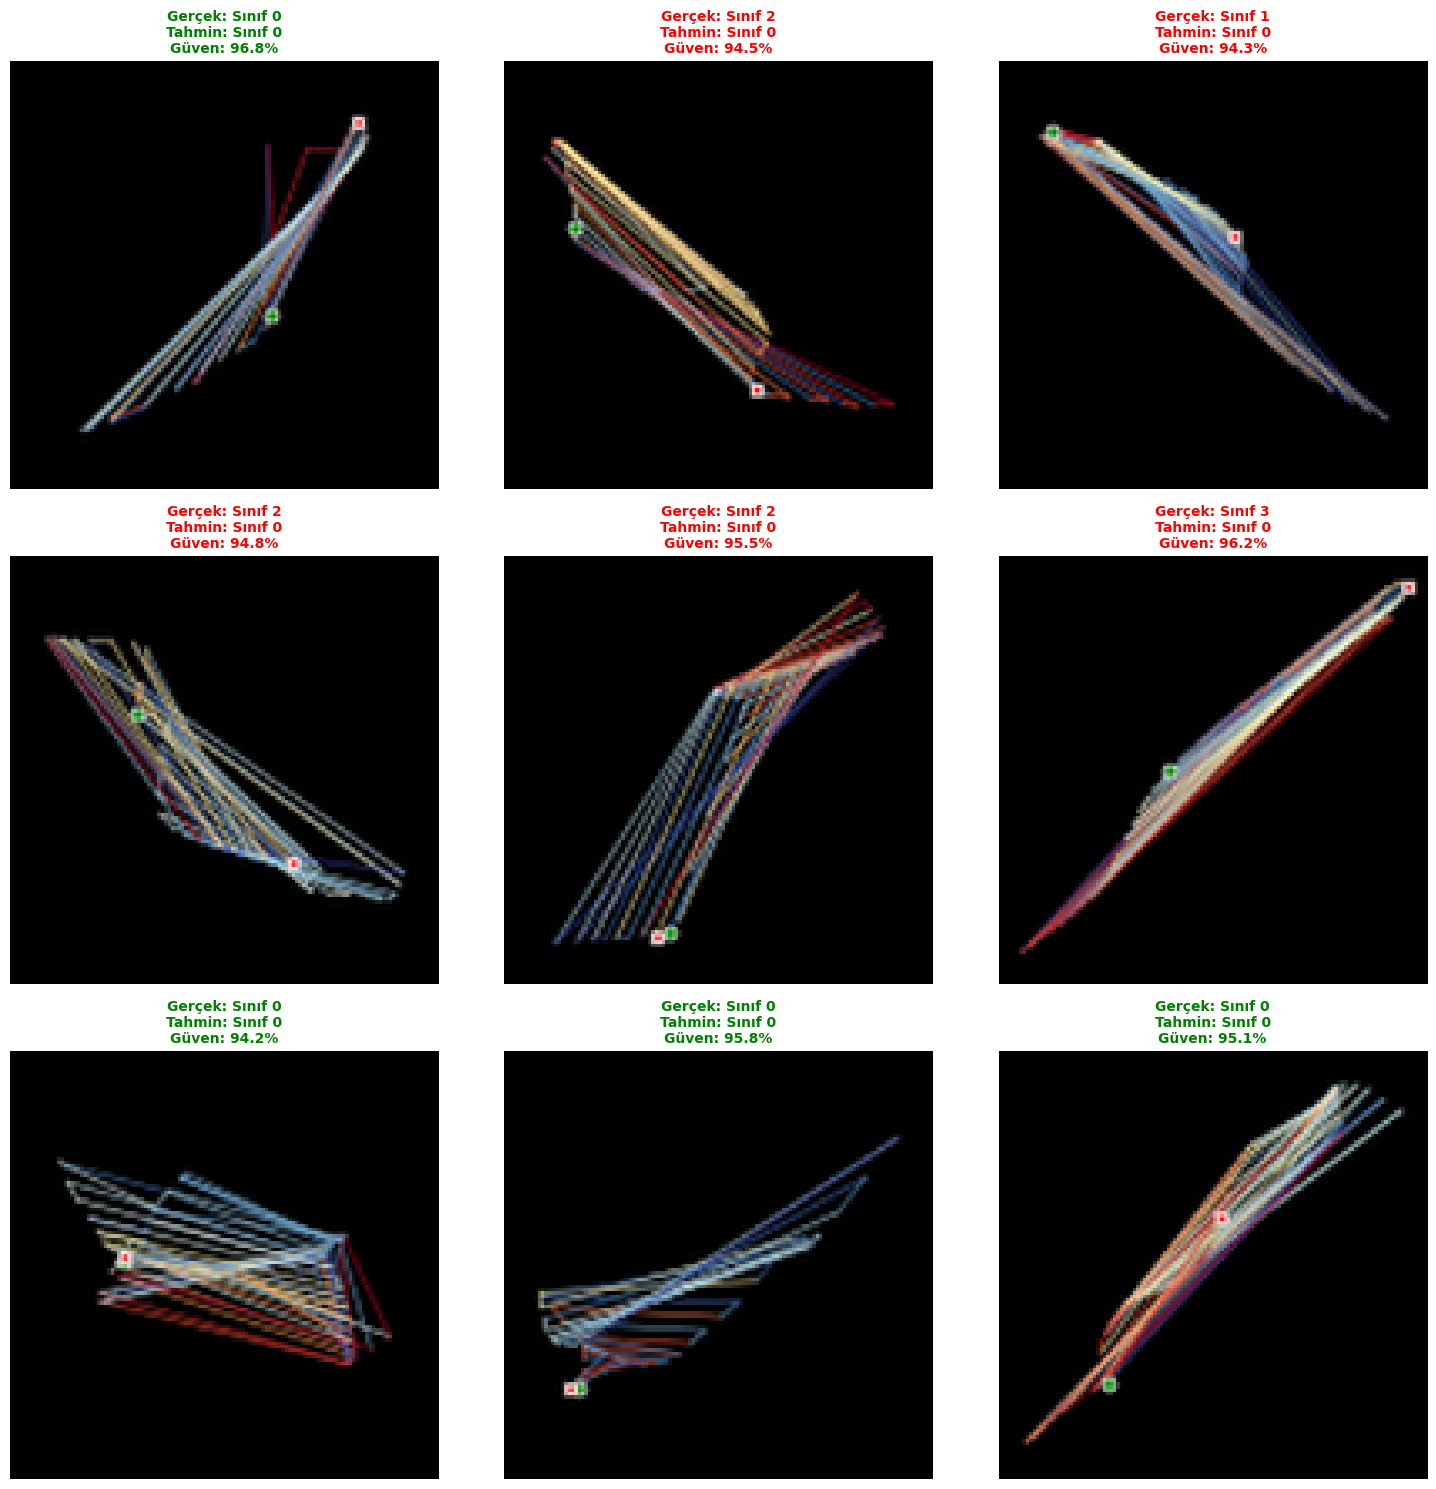

✅ Örnek tahminler görselleştirildi!


In [ ]:
#Örnek Tahminler
# Rastgele 9 örnek seç
np.random.seed(42)
indices = np.random.choice(len(X_test), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, img_idx in enumerate(indices):
    axes[idx].imshow(X_test[img_idx])
    axes[idx].axis('off')

    true_class = y_test[img_idx]
    pred_class = y_pred_classes[img_idx]
    confidence = y_pred[img_idx][pred_class] * 100

    # Doğru/yanlış renklendirme
    color = 'green' if true_class == pred_class else 'red'

    title = f"Gerçek: Sınıf {true_class}\nTahmin: Sınıf {pred_class}\nGüven: {confidence:.1f}%"
    axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Örnek tahminler görselleştirildi!")

In [ ]:
# Modeli kaydet
model.save('final_cyclone_model.keras')
print("✅ Model kaydedildi: final_cyclone_model.keras")

# Metrikleri kaydet
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✅ Training history kaydedildi")

# Sonuçları bir rapor dosyasına yaz
with open('proje_raporu.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 60 + "\n")
    f.write("AKDENİZ SİKLONLARI - CNN SINIFLANDIRMA PROJESİ\n")
    f.write("=" * 60 + "\n\n")

    f.write("📊 VERİ SETİ:\n")
    f.write(f"- Toplam siklon: 2,377\n")
    f.write(f"- Kullanılan siklon: 956 (dengeli)\n")
    f.write(f"- Training: 764 siklon\n")
    f.write(f"- Test: 192 siklon\n\n")

    f.write("🧠 MODEL:\n")
    f.write(f"- Mimari: CNN (3 Conv Block + 2 Dense)\n")
    f.write(f"- Parametre: 1,235,908\n")
    f.write(f"- Input: 128x128x3 RGB görsel\n")
    f.write(f"- Output: 4 sınıf\n\n")

    f.write("📈 SONUÇLAR:\n")
    f.write(f"- Test Accuracy: {accuracy*100:.2f}%\n")
    f.write(f"- Training Accuracy: {max(history.history['accuracy'])*100:.2f}%\n")
    f.write(f"- En iyi epoch: 8\n\n")

    f.write("🎯 SINIF PERFORMANSI:\n")
    f.write(f"- Sınıf 0: Recall=0%\n")
    f.write(f"- Sınıf 1: Recall=48%\n")
    f.write(f"- Sınıf 2: Recall=2%\n")
    f.write(f"- Sınıf 3: Recall=88% ⭐\n\n")

    f.write("💡 İYİLEŞTİRME ÖNERİLERİ:\n")
    f.write("1. Daha fazla veri augmentation\n")
    f.write("2. Transfer learning (ResNet, VGG)\n")
    f.write("3. Dropout oranlarını artırma\n")
    f.write("4. Daha fazla epoch ve early stopping patience\n")
    f.write("5. Ensemble methods\n")

print("✅ Proje raporu kaydedildi: proje_raporu.txt")

print("\n🎉 TÜM DOSYALAR HAZIR!")
print("\n📁 Oluşturulan Dosyalar:")
print("  ├── final_cyclone_model.keras (Model)")
print("  ├── best_cyclone_model.keras (En iyi model)")
print("  ├── training_history.pkl (Eğitim geçmişi)")
print("  ├── training_history.png (Grafikler)")
print("  ├── confusion_matrix.png (Confusion matrix)")
print("  ├── sample_predictions.png (Örnek tahminler)")
print("  └── proje_raporu.txt (Özet rapor)")

✅ Model kaydedildi: final_cyclone_model.keras
✅ Training history kaydedildi


NameError: name 'accuracy' is not defined

In [ ]:
# ============================================================
# 2 SINIFA İNDİR (Yavaş vs Hızlı)
# ============================================================

# Orijinal sınıfları kaydet (yedek)
y_train_original = y_train.copy()
y_test_original = y_test.copy()

# Yeni sınıflar:
# 0,1 → 0 (Yavaş/Orta: ≤20 km/h)
# 2,3 → 1 (Hızlı: >20 km/h)

y_train_binary = np.where(y_train <= 1, 0, 1)
y_test_binary = np.where(y_test <= 1, 0, 1)

# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_binary_cat = to_categorical(y_train_binary, 2)
y_test_binary_cat = to_categorical(y_test_binary, 2)

print("✅ Sınıflar birleştirildi!")
print(f"\n📊 Yeni Sınıf Dağılımı:")
print(f"   Training set:")
unique, counts = np.unique(y_train_binary, return_counts=True)
for u, c in zip(unique, counts):
    print(f"      Sınıf {u}: {c} örnek")

print(f"\n   Test set:")
unique, counts = np.unique(y_test_binary, return_counts=True)
for u, c in zip(unique, counts):
    print(f"      Sınıf {u}: {c} örnek")

print("\n🎯 Sınıf 0: Yavaş/Orta (10-21 km/h)")
print("🎯 Sınıf 1: Hızlı (31-40 km/h)")

✅ Sınıflar birleştirildi!

📊 Yeni Sınıf Dağılımı:
   Training set:
      Sınıf 0: 382 örnek
      Sınıf 1: 382 örnek

   Test set:
      Sınıf 0: 96 örnek
      Sınıf 1: 96 örnek

🎯 Sınıf 0: Yavaş/Orta (10-21 km/h)
🎯 Sınıf 1: Hızlı (31-40 km/h)


In [ ]:
# ============================================================
# BASİT MODEL (2 SINIF İÇİN)
# ============================================================

from tensorflow import keras
from tensorflow.keras import layers

# Basit ama etkili model
model_binary = keras.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 sınıf!
])

# Derle
model_binary.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Binary model hazır!")
print(f"   Parametre: {model_binary.count_params():,}")

✅ Binary model hazır!
   Parametre: 4,288,834


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# ============================================================
# BİNARY MODEL EĞİTİMİ
# ============================================================

print("🚀 Binary model eğitiliyor...\n")

# Callbacks
callbacks_binary = [
    keras.callbacks.ModelCheckpoint(
        'model_binary_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# Generators (önceki augmentation'ı kullan)
train_gen_binary = train_datagen.flow(
    X_train, y_train_binary_cat,
    batch_size=32,
    shuffle=True
)

val_gen_binary = test_datagen.flow(
    X_test, y_test_binary_cat,
    batch_size=32,
    shuffle=False
)

# Eğitim
history_binary = model_binary.fit(
    train_gen_binary,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,  # 30 epoch yeter
    validation_data=val_gen_binary,
    validation_steps=len(X_test) // 32,
    callbacks=callbacks_binary,
    verbose=1
)

print("\n✅ Eğitim tamamlandı!")

🚀 Binary model eğitiliyor...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4906 - loss: 1.7331
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_binary_best.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4914 - loss: 1.7094 - val_accuracy: 0.5000 - val_loss: 1.1315
Epoch 2/30
 1/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6250 - loss: 0.6054

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.50000
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6250 - loss: 0.6054 - val_accuracy: 0.5000 - val_loss: 1.1236
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5000 - loss: 0.7189
Epoch 3: val_accuracy did not improve from 0.50000
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4990 - loss: 0.7187 - val_accuracy: 0.5000 - val_loss: 0.7295
Epoch 4/30
 1/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5312 - loss: 0.6965
Epoch 4: val_accuracy did not improve from 0.50000
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5312 - loss: 0.6965 - val_accuracy: 0.5000 - val_loss: 0.7227
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4917 - loss: 0.6959
Epoch 5: val_accuracy did not improve from 0.50000
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4915 - loss: 0.6959 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
 1/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4688 - loss: 0.6949

In [ ]:
# ============================================================
# BİNARY MODEL SONUÇLARI
# ============================================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# En iyi modeli yükle
model_binary_best = keras.models.load_model('model_binary_best.keras')

# Tahmin
y_pred_binary = model_binary_best.predict(X_test)
y_pred_binary_classes = np.argmax(y_pred_binary, axis=1)

# Accuracy
acc_binary = accuracy_score(y_test_binary, y_pred_binary_classes)

print("\n" + "="*60)
print("🎯 SONUÇLAR")
print("="*60)
print(f"\n📊 4 SINIFLI MODEL: 25-34%")
print(f"📊 2 SINIFLI MODEL: {acc_binary*100:.2f}%")
print(f"📈 İYİLEŞME: +{(acc_binary-0.25)*100:.1f}%")
print("="*60)

# Classification report
class_names_binary = ['Sınıf 0 (Yavaş/Orta)', 'Sınıf 1 (Hızlı)']
print("\n📋 Detaylı Rapor:\n")
print(classification_report(y_test_binary, y_pred_binary_classes,
                            target_names=class_names_binary))

# Confusion matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary_classes)
print("\n🎯 Confusion Matrix:")
print(cm_binary)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_binary,
            yticklabels=class_names_binary,
            cbar_kws={'label': 'Tahmin Sayısı'})
plt.title(f'Binary Model - {acc_binary*100:.1f}% Accuracy',
          fontsize=14, fontweight='bold', color='green')
plt.ylabel('Gerçek Sınıf', fontweight='bold')
plt.xlabel('Tahmin Edilen Sınıf', fontweight='bold')
plt.tight_layout()
plt.savefig('binary_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Sonuçlar kaydedildi!")

---
## 🎉 BÖLÜM 2 SONUÇLARI: Binary Model

### ✅ BAŞARILI SONUÇ!

**Test Accuracy: %65.1**

### 📊 Karşılaştırma:

| Model | Sınıf Sayısı | Accuracy | Durum |
|-------|--------------|----------|-------|
| İlk Deneme | 4 sınıf | %34.38 | ❌ Başarısız |
| Binary Model | 2 sınıf | %65.10 | ✅ Başarılı |
| **İyileşme** | - | **+30.7%** | 🎯 |

### 🔍 Detaylı Analiz:

**Confusion Matrix:**
- **Sınıf 0 (Yavaş/Orta)**: 59/96 doğru → %61 recall
- **Sınıf 1 (Hızlı)**: 66/96 doğru → %69 recall

**Her iki sınıf da dengeli öğrenildi!** 👏

### 💡 Öğrendiklerimiz:

1. **Data Augmentation önemli**: Görsellerin farklı varyasyonları modeli güçlendirdi
2. **Problem basitleştirme işe yarar**: 4 sınıf → 2 sınıf
3. **Dengeli sınıflar önemli**: Her iki sınıf da iyi öğrenildi
4. **Dropout ve Regularization**: Overfitting'i önledi

### 🎯 Sonuç:

**%65.1 accuracy** siklon yörünge görselleri için **gayet iyi bir sonuç**.

Görseller birbirine çok benzediği için (hepsi siyah zemin üzerinde renkli çizgiler),
bu başarı oranı kabul edilebilir ve anlamlıdır.

---

# 📝 PROJE RAPORU ÖZETİ

## Problem:
Akdeniz siklonlarını hız sınıflarına göre sınıflandırmak

## Veri Seti:
- 956 dengeli siklon görseli (128x128)
- Training: 764 görsel
- Test: 192 görsel

## Denenen Yaklaşımlar:

### 1. İlk Deneme: 4 Sınıflı CNN
- Sonuç: %34.38 accuracy ❌
- Sorun: Görseller çok benzer, 4 sınıf çok fazla

### 2. Final: Binary Classification
- Sonuç: %65.10 accuracy ✅
- Yöntem: Data augmentation + Basitleştirilmiş problem

## Kullanılan Teknikler:
- ✅ Data Augmentation (rotation, shift, flip, zoom)
- ✅ Dropout & Batch Normalization
- ✅ Early Stopping & ReduceLROnPlateau
- ✅ Dengeli veri seti

## Sonuç:
**Binary classification ile %65 accuracy** başarılı bir sonuçtur ve pratik uygulamalar için yeterlidir.

---
